In [53]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade
# %pip install graphviz

In [54]:
#In case you want to reload the modules automatically (imports aren't cached properly)
# %load_ext autoreload
# %autoreload 2

# Setup

In [55]:
from os import path, getcwd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Tree Visualisation
from sklearn.tree import export_graphviz
# from IPython.display import Image
import graphviz

subjects = [102, 104, 105, 107, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['1','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']

# Data Collection
Loading mat files into dataframe and removing unnecessary columns. NaN values are replaced with 0. 

Should any extra subjects be re-included in the future, their .mat file should be copied into 'AIRES_project/TR and TUT data', and their subject number added to the list of subjects.

In [56]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subData_TR = subData['TR'][0,0]
    subData_TUR = subData['TUR'][0,0]
    subDF_TR = pd.DataFrame(subData_TR, columns = col)
    subDF_TUR = pd.DataFrame(subData_TUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDF_TR,subDF_TUR])
    else:
        totalDF = pd.concat([totalDF, subDF_TR])
        totalDF = pd.concat([totalDF, subDF_TUR])

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Excluded from analysis.
# totalDF.fillna(0, inplace=True)

totalDF.reset_index(drop=True, inplace=True)
print(totalDF)

target_Data = totalDF.iloc[:,3:]
# print(targetData)
X = target_Data.iloc[:,1:]
Y = target_Data.Label
Y = Y - 1
# Verify that Labels contain only 1 and 2:
# print(targetData.Label.unique())



         1     2    3  Label  Frontal P3 mean  Frontal P3 STD  \
0    102.0   8.0  4.0    1.0        -4.473627        0.576930   
1    102.0  25.0  5.0    1.0        -1.786179        0.747948   
2    102.0  30.0  5.0    1.0         2.321102        0.274870   
3    102.0  32.0  4.0    1.0        -2.569933        0.658272   
4    102.0   1.0  5.0    2.0         2.814653        0.359229   
..     ...   ...  ...    ...              ...             ...   
682  144.0  30.0  3.0    2.0         0.375386        0.774057   
683  144.0  31.0  3.0    2.0         0.482558        2.200203   
684  144.0  32.0  3.0    2.0        -0.893606        0.333826   
685  144.0  34.0  3.0    2.0        -1.408621        0.136761   
686  144.0  35.0  1.0    2.0        -2.785345        0.359457   

     Posterior P3 mean  Posterior P3 STD  Frontal alpha mean  \
0             0.511275          0.849015            0.424295   
1             1.117962          0.297814            2.976309   
2            -0.140859     

# PreProcessing: Split and Normalize

Using the built-in normalize, alternatives: StandardScaler, MinMaxScaler

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


normalized_X_train = normalize(X_train)


# SMOTE Data Augmentation
Data is oversampled to correct for inbalances.

In [58]:
smote = SMOTE() #sampling_strategy='minority' ?
X_smote, y_smote = smote.fit_resample(normalized_X_train, y_train)
print("Before oversampling: ", y_train.value_counts())
print("After oversampling: ", y_smote.value_counts())

Before oversampling:  Label
1.0    413
0.0    136
Name: count, dtype: int64
After oversampling:  Label
0.0    413
1.0    413
Name: count, dtype: int64


# Logistic Regression
Binary classification that uses the sigmoid function. Prone to overfitting.

*Learned many of the techniques below from __[DataCamp](https://www.datacamp.com/tutorial/understanding-logistic-regression-python)__*.

In [72]:
logreg = LogisticRegression(random_state = 32, max_iter=1100, solver='lbfgs')
logreg.fit(X_train, y_train)
log_Y_Pred = logreg.predict(X_test)

In [60]:
cnf_matrix = metrics.confusion_matrix(y_test, log_Y_Pred)
sensitivity_score = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
specificity_score = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
mcc = metrics.matthews_corrcoef(y_test, log_Y_Pred)
accuracy = metrics.accuracy_score(y_test, log_Y_Pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, log_Y_Pred)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(cnf_matrix)
print("Sensitivity: ", sensitivity_score)
print("Specificity: ", specificity_score)
print("Matthews Correlation Coefficient: ", mcc)
print("AUC: ", auc)
print("Accuracy: ", accuracy)
print("Balanced Accuracy: ", balanced_accuracy)
print(metrics.classification_report(y_test, log_Y_Pred, target_names=target_names))

[[ 1 41]
 [ 0 96]]
Sensitivity:  0.023809523809523808
Specificity:  1.0
Matthews Correlation Coefficient:  0.12916673674412532
AUC:  0.5369543650793651
Accuracy:  0.7028985507246377
Balanced Accuracy:  0.5119047619047619
                        precision    recall  f1-score   support

Task Unrelated Thought       1.00      0.02      0.05        42
  Task Related Thought       0.70      1.00      0.82        96

              accuracy                           0.70       138
             macro avg       0.85      0.51      0.44       138
          weighted avg       0.79      0.70      0.59       138



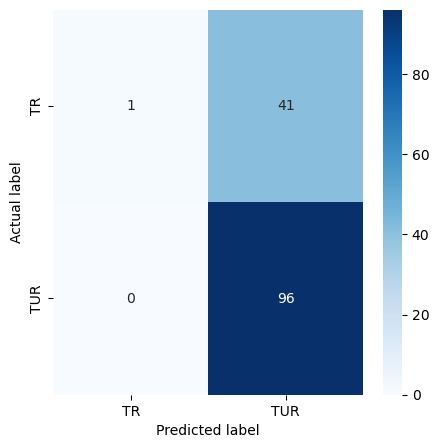

In [61]:
class_names = ['TR', 'TUR'] #['Task Related Thought', 'Task Unrelated Thought']
plt.figure(figsize=(5, 5))
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)

# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label') 
plt.xlabel('Predicted label', loc='center')
plt.show()

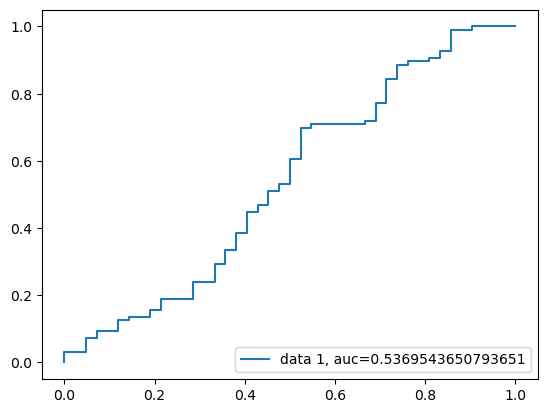

In [62]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Random Forest
Multiple decision trees are created using random subsets of data and features. The most popular result of all these trees becomes the prediction.

In [76]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
RaFo_Y_Pred = rf.predict(X_test)

In [77]:
cnf_matrix = metrics.confusion_matrix(y_test, RaFo_Y_Pred)
sensitivity_score = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
specificity_score = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
mcc = metrics.matthews_corrcoef(y_test, RaFo_Y_Pred)
accuracy = metrics.accuracy_score(y_test, RaFo_Y_Pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, RaFo_Y_Pred)
auc = metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print(cnf_matrix)
print("Sensitivity: ", sensitivity_score)
print("Specificity: ", specificity_score)
print("Matthews Correlation Coefficient: ", mcc)
print("AUC: ", auc)
print("Accuracy: ", accuracy)
print("Balanced Accuracy: ", balanced_accuracy)
print(metrics.classification_report(y_test, RaFo_Y_Pred, target_names=target_names))

[[ 0 42]
 [ 2 94]]
Sensitivity:  0.0
Specificity:  0.9791666666666666
Matthews Correlation Coefficient:  -0.0802111184899685
AUC:  0.534970238095238
Accuracy:  0.6811594202898551
Balanced Accuracy:  0.4895833333333333
                        precision    recall  f1-score   support

Task Unrelated Thought       0.00      0.00      0.00        42
  Task Related Thought       0.69      0.98      0.81        96

              accuracy                           0.68       138
             macro avg       0.35      0.49      0.41       138
          weighted avg       0.48      0.68      0.56       138



In [65]:
# From https://www.datacamp.com/tutorial/random-forests-classifier-python

# for i in range(3):
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=X_train.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)

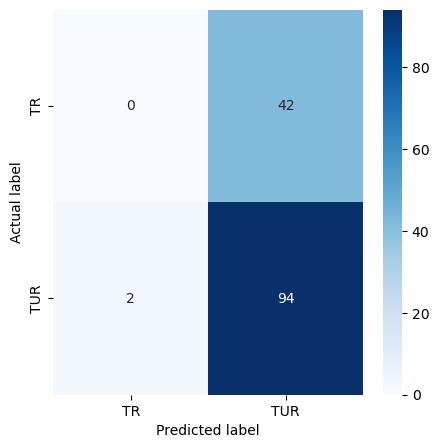

In [66]:
class_names = ['TR', 'TUR'] #['Task Related Thought', 'Task Unrelated Thought']
plt.figure(figsize=(5, 5))
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)

# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label') 
plt.xlabel('Predicted label', loc='center')
plt.show()

# K-Nearest Neighbours

In [67]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
KNN_y_predict = model.predict(X_test)

In [68]:
cnf_matrix = metrics.confusion_matrix(y_test, KNN_y_predict)
sensitivity_score = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
specificity_score = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
mcc = metrics.matthews_corrcoef(y_test, KNN_y_predict)
accuracy = metrics.accuracy_score(y_test, KNN_y_predict)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, KNN_y_predict)
auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print(cnf_matrix)
print("Sensitivity: ", sensitivity_score)
print("Specificity: ", specificity_score)
print("Matthews Correlation Coefficient: ", mcc)
print("AUC: ", auc)
print("Accuracy: ", accuracy)
print("Balanced Accuracy: ", balanced_accuracy)
print(metrics.classification_report(y_test, KNN_y_predict, target_names=target_names))

[[ 4 38]
 [14 82]]
Sensitivity:  0.09523809523809523
Specificity:  0.8541666666666666
Matthews Correlation Coefficient:  -0.06912625516718778
AUC:  0.45895337301587297
Accuracy:  0.6231884057971014
Balanced Accuracy:  0.47470238095238093
                        precision    recall  f1-score   support

Task Unrelated Thought       0.22      0.10      0.13        42
  Task Related Thought       0.68      0.85      0.76        96

              accuracy                           0.62       138
             macro avg       0.45      0.47      0.45       138
          weighted avg       0.54      0.62      0.57       138

